Build a baseline model using the weather station data (this approach used all days in 2018 since the data was available).


Then use the model to make predictions for the ENVI-met(micro-climate) data for that specific day and compare it to model predictions using weather station data also for the same day.

# 1. Import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pathlib
import pickle

import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
from sklearn import metrics

#  for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import PyQt5

# 2. Import Files

## 2.1 Save csv files as pickle

Only run this once to save our csv data as pickle files

In [ ]:
# --> NO NEED TO RUN SAVED AS PICKLE FILES <--
# WEATHER FILES ##

# # AZ PHX Sky Harbor Data #
# AZW_15 = pd.read_csv("./Data/Weather Data/KPHX-15.csv")

# # ENVIMET DATA #
# BPS = []
# Fname = []
# for path in pathlib.Path("./Data/BPS").iterdir():
#     if path.is_file():
#         current_file = pd.read_csv(path)
#         BPS.append(current_file)
#         Fname.append(path.name.replace('.csv', ''))

# # CAMPUS METABOLISM DATA #
# metabol14 = []
# for path in pathlib.Path('./Data/ASU 2018').iterdir():
#     if path.is_file():
#         current_file = pd.read_csv(path)
#         metabol14.append(current_file)

# ## Drop last row of EnviMet Data
# for i in range(len(BPS)):
#     BPS[i] = BPS[i].drop(16)

# ## Save files as pickle
# AZW_15.to_pickle("./Data/AZW_15.pkl")

# with open('./Data/BPS.pkl', 'wb') as f:
#     pickle.dump(BPS, f)

# with open('./Data/Fname.pkl', 'wb') as f:
#     pickle.dump(Fname, f)

# with open('./Data/metabol14.pkl', 'wb') as f:
#     pickle.dump(metabol14, f)

## 2.2 Reload Pickle

In [2]:
# We will convert these to df depending on the building we choose
# 2. Load 14 envimet bldgData (14 filtered buildings)
with open('./Data/BPS.pkl', 'rb') as f:
    envi14 = pickle.load(f)

# 3. Load names of BPS files
with open('./Data/Fname.pkl', 'rb') as f:
    Fname = pickle.load(f)

# 4. Load 14 campus metabolism building energy data
with open('./Data/metabol14.pkl', 'rb') as f:
    metabol14 = pickle.load(f)

## 2.3 Choose building name to import

In [3]:
##Print Building Names ##
for i in range(len(Fname)):
    print(Fname[i])
    
bldname = input('Enter building name: ')

for i in range(len(envi14)):
    if bldname == Fname[i]:
        # save 
        envi_bldg = envi14[i]

if bldname not in Fname:
    print("\x1b[31m\"Please enter a valid name from the list above\"\x1b[0m")


Health Services
Interdisciplinary AB
Bio Design Institute A
Lifescience A_B_D
Bio Design Institute B
COD North
Goldwater
University Club
Engineering Research Ctr
Best Hall
ISTB 1
ISTB 2
ISTB 4
ISTB 5


Enter building name:  Health Services


## 2.4 Create Data Frame

In [4]:
class building:
    
    def __init__(self, bldgname):
        self.bldgname = bldgname
    
    def campusmetabolism(self):
        for i in range(len(metabol14)):
            if metabol14[i]['bldgname'][0] == bldname:
                cmp = metabol14[i]
            elif (metabol14[i]['bldgname'][0] == 'ISTB-5'):
                cmp = metabol14[i]
        return cmp
    
    def envimet(self):
        env = envi_bldg[['Date', 'Time', 'AirTempInFrontOfAllFacades_MEAN', 'RelativeAirHumidityInFrontOfAllFacades_MEAN',
                     'WindSpeedInFrontOfAllFacades_MEAN']]
        
        env = env.rename(columns = {'AirTempInFrontOfAllFacades_MEAN':'Air Temp',
                                    'RelativeAirHumidityInFrontOfAllFacades_MEAN':'Rel Humid',
                                    'WindSpeedInFrontOfAllFacades_MEAN':'Wind Speed'})
        return env


Bldg = building(bldname)
metabol = Bldg.campusmetabolism() # campus metabolism
envimet = Bldg.envimet()          # envimet
print(bldname)

Health Services


In [5]:
# DF for AZ Weather Data (15-min)
weather_station = pd.read_pickle('./Data/AZW_15.pkl')

# 3. Preprocessing

## 3.1 Formatting Date and Time

### a) Envimet dates

In [6]:
# 1. format time
envimet['Time'] = envimet['Time'].str.replace('.',':')
envimet['Time'] = envimet['Time'].str.replace('01','00')

# convert to 24 hour format
envimet['Time'] = pd.to_datetime(envimet['Time']).dt.strftime('%H:%M')

# 2. format date (still in string)
envimet['Date'] = pd.to_datetime(envimet['Date']).dt.strftime('%m/%d/%Y')

# 3. combine date time column as string and set as index
envimet['Date_Time'] = envimet['Date'] + ' ' + envimet['Time']

# 4. Get string type for month and time
envimet['Month'] = envimet['Date_Time'].str[0:2]
envimet['Time'] = envimet['Time'].str.replace(':','')

# 5. Rearrange columns
print(list(envimet.columns))
envimet = envimet[['Date_Time','Month','Time', 'Air Temp', 'Rel Humid' ]]

envimet = envimet.set_index('Date_Time')


['Date', 'Time', 'Air Temp', 'Rel Humid', 'Wind Speed', 'Date_Time', 'Month']


<ipython-input-6-9e6431319558>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  envimet['Time'] = envimet['Time'].str.replace('.',':')


In [ ]:
# # 5. Get numeric for month hour and minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time)
# microclimate['Month_num'] = microclimate.Date_Time.dt.month
# microclimate['Hour_num'] = microclimate.Date_Time.dt.hour
# microclimate['Minute_num'] = microclimate.Date_Time.dt.minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

# # 6. Rearrange columns
# print(list(microclimate.columns))
# microclimate = microclimate[['Date_Time','Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid' ]]

### b) Weather Station dates

In [7]:
# 1. Get string type for month and time
weather_station['Month'] = weather_station['Date_Time'].str[0:2]
weather_station['Time'] = weather_station['Date_Time'].str[11:]
weather_station['Time'] = weather_station['Time'].str.replace(':','')

# 2. Get numeric for month hour and minute
weather_station.Date_Time = pd.to_datetime(weather_station.Date_Time)
weather_station['Month_num'] = weather_station.Date_Time.dt.month
weather_station['Hour_num'] = weather_station.Date_Time.dt.hour
weather_station['Minute_num'] = weather_station.Date_Time.dt.minute
weather_station.Date_Time = pd.to_datetime(weather_station.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

# 3. set date time as index
weather_station = weather_station.set_index('Date_Time') 

### c) Building energy dates

In [8]:
metabol.tstamp = pd.to_datetime(metabol.tstamp).dt.strftime('%m/%d/%Y %H:%M')

# remove unwanted columns
metabol = metabol[['tstamp','KW', 'CHWTON']]

# set date time as index
metabol = metabol.set_index('tstamp')

## 3.2 Append Energy Consumption to Weather Station data

In [9]:
weather_station =  pd.concat([metabol, weather_station], axis = 1, join = "inner")

# rearrange column
weather_station = weather_station[['Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid', 'KW','CHWTON' ]]

# weather_station.to_csv('./Data/weather_st_numstr') # save data with string and numeric date format

In [10]:
weather_station.to_csv('./Data/weather_station_numstr') # save data with string and numeric date format


# 4. Create June 9th Data 

For both microclimate and weather_station

## 4.1 For Microclimate

We want: month, hour, minute, CHWTON, KW, date, air temp, and real humidity for microclimate June 9th.
We do this by merging with building_energy to get KW and CHWTON on the dates that appear in microclimate data



In [11]:
envimet_j9 = pd.merge(envimet, metabol, left_index = True, right_index = True)
envimet_j9

,Month,Time,Air Temp,Rel Humid,KW,CHWTON
06/09/2018 05:00,06,0500,29.623496,12.619686,41.47,28.28
06/09/2018 06:00,06,0600,28.549299,17.690813,42.48,26.82
06/09/2018 07:00,06,0700,29.207824,18.597957,53.76,28.56
06/09/2018 08:00,06,0800,31.168043,18.030991,52.02,34.90
06/09/2018 09:00,06,0900,33.664592,15.529563,51.25,34.90
06/09/2018 10:00,06,1000,35.660266,11.340313,51.92,40.98
06/09/2018 11:00,06,1100,36.756933,9.115357,53.32,49.19
06/09/2018 12:00,06,1200,37.748763,7.874358,54.52,51.74
06/09/2018 13:00,06,1300,38.719150,7.006677,54.21,53.42
06/09/2018 14:00,06,1400,39.422077,6.311791,52.02,53.22


## 4.2 For Weather Station

In [12]:
# 1. Convert to datetime so we can remove June 9th weather
weather_station.index = pd.to_datetime(weather_station.index)

# 2. Extract all of june 9th data 
station_j9 = weather_station[(weather_station.index.month == 6) & (weather_station.index.day == 9)]

# 3. drop all of June 9th from weather_station data
weather_station = weather_station.drop(station_j9.index)

# 4. Filter time ( only minute 00) from june 9th data
station_j9 = station_j9[ (station_j9['Hour_num'] >= 5) & (station_j9['Hour_num'] <= 20) & (station_j9['Minute_num'] == 0)]

# 5. drop numeric variables
weather_station = weather_station.drop(labels = ['Hour_num', 'Month_num','Minute_num'], axis = 1)
station_j9 = station_j9.drop(labels = ['Hour_num', 'Month_num','Minute_num'], axis = 1)

# 6. ensure theres no more june 9th data between 5am to 8pm on weather_station data
print(weather_station[(weather_station.index.month == 6) & (weather_station.index.day == 9)])

# 7. convert index back to string types
weather_station.index = pd.to_datetime(weather_station.index).strftime('%m/%d/%Y %H:%M')
station_j9.index = pd.to_datetime(station_j9.index).strftime('%m/%d/%Y %H:%M')
station_j9


Empty DataFrame
Columns: [Month, Time, Air Temp, Rel Humid, KW, CHWTON]
Index: []


,Month,Time,Air Temp,Rel Humid,KW,CHWTON
06/09/2018 05:00,06,0500,27.0,14.84,41.47,28.28
06/09/2018 06:00,06,0600,26.0,15.74,42.48,26.82
06/09/2018 07:00,06,0700,28.0,17.42,53.76,28.56
06/09/2018 08:00,06,0800,31.0,11.78,52.02,34.90
06/09/2018 09:00,06,0900,33.0,9.06,51.25,34.90
06/09/2018 10:00,06,1000,35.0,7.52,51.92,40.98
06/09/2018 11:00,06,1100,37.0,6.74,53.32,49.19
06/09/2018 12:00,06,1200,39.0,5.19,54.52,51.74
06/09/2018 13:00,06,1300,41.0,4.32,54.21,53.42
06/09/2018 14:00,06,1400,41.0,3.99,52.02,53.22


In [ ]:
# save as csv
station_j9.to_csv('./Data/station_j9')
envimet_j9.to_csv('./Data/envimet_j9')

In [13]:
weather_station

,Month,Time,Air Temp,Rel Humid,KW,CHWTON
01/01/2018 00:00,01,0000,11.0,40.24,33.92,0.11
01/01/2018 00:15,01,0015,11.0,40.24,33.45,0.13
01/01/2018 00:30,01,0030,10.0,43.01,33.60,0.10
01/01/2018 00:45,01,0045,9.0,46.00,33.50,0.08
01/01/2018 01:00,01,0100,9.0,46.00,33.53,0.04
...,...,...,...,...,...,...
12/31/2018 22:00,12,2200,6.0,93.30,67.90,0.00
12/31/2018 22:15,12,2215,5.0,100.00,63.80,0.00
12/31/2018 22:30,12,2230,5.0,100.00,65.59,0.01
12/31/2018 22:45,12,2245,6.0,93.30,67.86,0.00


# 5. EDA

## 5.1 Correlation Matrix

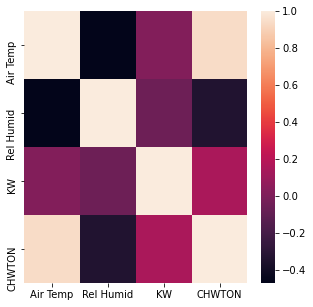

In [14]:
corrMatrix = weather_station.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corrMatrix)
plt.show()

## 5.2 Multicolinearity

A simple method to detect multicollinearity in a model is by using something called the variance inflation factor or the VIF for each predicting variable. An acceptable VIF is if it’s less than the max of 10

In [15]:
## Get X and Y
Y = weather_station['CHWTON']
X = weather_station.drop(labels = ['CHWTON'], axis = 1)

X_int = X.drop(labels = ['Month', 'Time'], axis = 1)

vif_data = pd.DataFrame()
vif_data["feature"] = X_int.columns
vif_data["VIF"] = [variance_inflation_factor(X_int.values, i) for i in range(len(X_int.columns))]

vif_data

,feature,VIF
0,Air Temp,5.756739
1,Rel Humid,2.928959
2,KW,8.549442


# 6. Model 1: Random Forest

Scoring:
One one hand, RMSE tells us the typical distance between the predicted value made by the regression model and the actual value.

On the other hand, R2 tells us how well the predictor variables can explain the variation in the response variable.

## 6.1 Train Test (all year)

In [16]:
############################ RANDOM FORESTS #################################
# 1. Get train test 
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

# 2. Using RandomForestRegressor to make predictions
from sklearn.ensemble import RandomForestRegressor
# - string
base_RF = RandomForestRegressor(n_estimators=100, random_state=42)
base_RF.fit(X_train, Y_train)

# 3. Get prediction
Y_pred = base_RF.predict(X_test)
ModelPred = pd.DataFrame({'Actual CHWTON':Y_test, 'Predicted CHWTON':Y_pred})
ModelPred = ModelPred.sort_index()
print(ModelPred)

                  Actual CHWTON  Predicted CHWTON
01/01/2018 00:15           0.13            0.0462
01/01/2018 00:30           0.10            0.0257
01/01/2018 00:45           0.08            0.0310
01/01/2018 02:00           0.02            0.0099
01/01/2018 03:15           0.01            0.0100
...                         ...               ...
12/31/2018 15:00           0.02            0.0333
12/31/2018 16:00           0.02            0.0207
12/31/2018 17:30           0.03            0.0379
12/31/2018 18:00           0.04            0.0311
12/31/2018 19:45           0.03            0.0462

[6906 rows x 2 columns]


In [17]:
# Custom functions for scoring
# 1. This function will returns R2 and RMSE score given a model and X, Y tests data
def evaluate(model, X_tests, Y_tests):
    Y_preds = model.predict(X_tests)
    R2 = model.score(X_tests, Y_tests)
    RMSE = np.sqrt(metrics.mean_squared_error(Y_tests, Y_preds))
    return [R2, RMSE]

# 2. This function will append a new all year score (row) to our scores data frame
def append_all_year_score(dataframe, score_list, model_name):
    i = dataframe.shape[0] # new index
    dataframe.loc[ i, 'model' ] = model_name
    dataframe.loc[ i, ('all_year','R2') ] = score_list[0]
    dataframe.loc[ i, ('all_year','RMSE') ] = score_list[1]
    return dataframe

# 3. This function will append a new June 9th score (column) to our scores data frame of the last row
def append_j9_score(dataframe, score_list, isEnvimet = False):
    data_name = 'weather_stn'
    if(isEnvimet == True):
        data_name = 'envimet'
        
    i = dataframe.shape[0] - 1 # last index
    dataframe.loc[i, (data_name, 'R2')] = score_list[0]
    dataframe.loc[i, (data_name, 'RMSE')] = score_list[1]

    return dataframe


# 4. This function will append all scores to score df
def get_model_score_df(pModel, pX_test, pY_test, pX_j9, pX_j9_envi, pY_j9, pScore_df, pModel_name):
    # 1. all year 
    all_year_score = evaluate(pModel, pX_test, pY_test)
    pScore_df = append_all_year_score(pScore_df, all_year_score, pModel_name) # append to score_df
    
    # 2. weather station
    weather_st_score = evaluate(pModel, pX_j9, pY_j9) 
    pScore_df = append_j9_score(pScore_df, weather_st_score, isEnvimet = False) 
    
    # 3. envimet
    envimet_score = evaluate(pModel, pX_j9_envi, pY_j9) # get score
    pScore_df = append_j9_score(pScore_df, envimet_score, isEnvimet = True)

    return pScore_df



In [18]:
# 1. get score
r2rmse = evaluate(base_RF, X_test, Y_test)

# 2. create score df
arrays = [["all_year", "all_year"],['R2', 'RMSE']]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples)
scores_df = pd.DataFrame([[2,1]], columns=index)

# 3. fill model name and score
scores_df['model'] = 'base RF'
scores_df['all_year', 'R2'] = r2rmse[0]
scores_df['all_year', 'RMSE'] = r2rmse[1]
scores_df = scores_df[['model', 'all_year']]
scores_df

model  all_year          
                  R2      RMSE
0  base RF  0.983295  2.694178

In [19]:
# Feature importance
feature_list = list(X_train.columns)
feature_imp = pd.Series(base_RF.feature_importances_, index=feature_list).sort_values(ascending=False)
print("\033[1m" + "Feature Importances:" + "\033[0m")
print(feature_imp, "\n")


Feature Importances:
Air Temp     0.888572
KW           0.049128
Rel Humid    0.038469
Month        0.012919
Time         0.010912
dtype: float64 



## 6.2 June 9th Prediction

### Weather Station

In [20]:
# 1. Get X and Y (all test)
X_j9 = station_j9.drop(labels = ['CHWTON'], axis = 1)
Y_j9 = station_j9['CHWTON']

# 2. calc scores 
base_score = evaluate(base_RF, X_j9, Y_j9)

# 3. insert scores to scores_df row 0 to 1
scores_df = append_j9_score(scores_df, base_score, isEnvimet = False)

### Microclimate

In [21]:
# 1. Get X and Y (all test)
X_j9_envi = envimet_j9 .drop(labels = ['CHWTON'], axis = 1)

# 2. calc scores 
base_score = evaluate(base_RF, X_j9_envi, Y_j9)

# 3. insert scores to scores_df row 0 to 1
scores_df = append_j9_score(scores_df, base_score, isEnvimet = True)
scores_df

model  all_year           weather_stn            envimet          
                  R2      RMSE          R2      RMSE       R2      RMSE
0  base RF  0.983295  2.694178    0.880146  4.012455  0.86099  4.321223

# 7. Model 2: RF using random search

## 7.1 Set parameters grid

In [22]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# 2. Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# 3. Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# 4. Minimum number of samples required at each leaf node
min_samples_leaf = [ 1, 2, 4]

# 5. Method of selecting samples for training each tree
bootstrap = [True, False]

# 6. Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


## 7.2 Train, Test, Score

In [23]:
# Use the random grid to search for best hyperparameters
# 1.Create the base model to tune
rf = RandomForestRegressor(random_state = 42)

# 2. Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               verbose = 2,
                               scoring ='r2',
                               random_state = 42,
                               n_jobs = -1)

# 3. Fit the random search model
rf_random.fit(X_train, Y_train)

# 4. print winning set of hyperparameters
from pprint import pprint
pprint(rf_random.best_estimator_.get_params())
pprint(rf_random.best_score_)

# 5. get the best model
random_RF = rf_random.best_estimator_


# 6. get all score as df
scores_df = get_model_score_df(random_RF,
                               X_test, Y_test,
                               X_j9,X_j9_envi,
                               Y_j9,
                               scores_df,
                               'random RF')    
scores_df 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
0.9834767532950155


model  all_year           weather_stn             envimet          
                    R2      RMSE          R2      RMSE        R2      RMSE
0    base RF  0.983295  2.694178    0.880146  4.012455  0.860990  4.321223
1  random RF  0.984783  2.571444    0.912587  3.426671  0.857326  4.377802

In [ ]:
# #  1. Get all yearscore
# random_rf_score = evaluate(random_RF, X_test, Y_test)
# scores_df = append_all_year_score(scores_df, random_rf_score , 'random RF')

# # 2. Weather Station
# random_score = evaluate(random_RF, X_j9, Y_j9)
# scores_df = append_j9_score(scores_df, random_score, isEnvimet = False)

# # 3. Microclimate
# random_score = evaluate(random_RF, X_j9_envi, Y_j9)
# scores_df = append_j9_score(scores_df, random_score, isEnvimet = True)
# scores_df

# 8. Model 3: Catboost

## 8.1 Grid Search

In [26]:
import catboost as cb

# 1. initialize model and grid
catboost = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'depth': [2, 4, 8, 10],
        'iterations': [50, 100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'l2_leaf_reg': [0.2, 0.5, 1, 3, 5]}


# 2. search parameter
train_dataset = cb.Pool(X_train, Y_train) 
test_dataset = cb.Pool(X_test, Y_test)
result = catboost.grid_search(grid,
                           train_dataset,
                           cv = 5,
                           search_by_train_test_split=True,
                           shuffle = True,
                           refit = True,
                           verbose = True,
                           train_size = 0.8 )


# 3. get best params
params = list(result['params'].values())

# 4. fit model with best params
grid_cb = cb.CatBoostRegressor(depth = params[0],  iterations = params[1], learning_rate= params[2], l2_leaf_reg = params[3])
grid_cb.fit(train_dataset)

# 5. get score as df
scores_df = get_model_score_df(grid_cb,
                               X_test, Y_test,
                               X_j9,X_j9_envi,
                               Y_j9,
                               scores_df,
                               'grid CB')    


0:	learn: 33.2341955	test: 33.2237875	best: 33.2237875 (0)	total: 13.2ms	remaining: 647ms
1:	learn: 32.3623149	test: 32.3481821	best: 32.3481821 (1)	total: 16.5ms	remaining: 397ms
2:	learn: 31.5198739	test: 31.5020842	best: 31.5020842 (2)	total: 20.4ms	remaining: 320ms
3:	learn: 30.6913262	test: 30.6704456	best: 30.6704456 (3)	total: 22.8ms	remaining: 262ms
4:	learn: 29.8719133	test: 29.8463807	best: 29.8463807 (4)	total: 25ms	remaining: 225ms
5:	learn: 29.0617777	test: 29.0337565	best: 29.0337565 (5)	total: 27.3ms	remaining: 201ms
6:	learn: 28.2979214	test: 28.2649372	best: 28.2649372 (6)	total: 29.7ms	remaining: 182ms
7:	learn: 27.5350634	test: 27.4999098	best: 27.4999098 (7)	total: 32ms	remaining: 168ms
8:	learn: 26.7970381	test: 26.7588756	best: 26.7588756 (8)	total: 34.4ms	remaining: 157ms
9:	learn: 26.1002755	test: 26.0590167	best: 26.0590167 (9)	total: 36.6ms	remaining: 147ms
10:	learn: 25.4142092	test: 25.3714249	best: 25.3714249 (10)	total: 38.8ms	remaining: 138ms
11:	learn: 2

In [28]:
scores_df 

model  all_year           weather_stn             envimet          
                    R2      RMSE          R2      RMSE        R2      RMSE
0    base RF  0.983295  2.694178    0.880146  4.012455  0.860990  4.321223
1  random RF  0.984783  2.571444    0.912587  3.426671  0.857326  4.377802
2    grid CB  0.981002  2.873171    0.953439  2.500904  0.885341  3.924538

In [25]:
params

[10, 200, 0.1, 0.2]

## 8.2 Random Search

In [29]:
catboost = cb.CatBoostRegressor(loss_function='RMSE')

# 1. hyperparameter grid
grid = {'iterations': [50, 100, 150, 200, 250],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 8, 10, 12],
        'l2_leaf_reg': [0.2, 0.5, 1, 3, 5, 7]}

# 2. instantiate RandomSearchCv object
catboost_random = RandomizedSearchCV(estimator = catboost,
                               param_distributions = grid,
                               n_iter = 20, cv = 5,
                               verbose = 2,
                               scoring ='r2',
                               random_state = 42,
                               n_jobs = -1)


# 3. Fit the model
catboost_random.fit(X_train,Y_train)

# 4. print winning set of hyperparameters
from pprint import pprint
pprint(catboost_random.best_estimator_.get_params())
pprint(catboost_random.best_score_)

# 5. get the best model
random_CB = catboost_random.best_estimator_

# 6. get score
scores_df = get_model_score_df(random_CB,
                               X_test, Y_test,
                               X_j9,X_j9_envi,
                               Y_j9,
                               scores_df,
                               'random CB')    


Fitting 5 folds for each of 20 candidates, totalling 100 fits
0:	learn: 18.9691784	total: 78.7ms	remaining: 19.6s
1:	learn: 17.2438152	total: 155ms	remaining: 19.3s
2:	learn: 15.7006617	total: 227ms	remaining: 18.7s
3:	learn: 14.3133560	total: 307ms	remaining: 18.9s
4:	learn: 13.0844080	total: 391ms	remaining: 19.2s
5:	learn: 11.9527347	total: 464ms	remaining: 18.9s
6:	learn: 10.9605332	total: 540ms	remaining: 18.7s
7:	learn: 10.0653195	total: 612ms	remaining: 18.5s
8:	learn: 9.2630064	total: 683ms	remaining: 18.3s
9:	learn: 8.5516435	total: 764ms	remaining: 18.3s
10:	learn: 7.9227958	total: 839ms	remaining: 18.2s
11:	learn: 7.3533326	total: 913ms	remaining: 18.1s
12:	learn: 6.8429621	total: 989ms	remaining: 18s
13:	learn: 6.3971479	total: 1.06s	remaining: 18s
14:	learn: 6.0011428	total: 1.14s	remaining: 17.8s
15:	learn: 5.6685291	total: 1.21s	remaining: 17.7s
16:	learn: 5.3651998	total: 1.28s	remaining: 17.6s
17:	learn: 5.0972046	total: 1.35s	remaining: 17.4s
18:	learn: 4.8586430	tota

In [30]:
print(bldname)
scores_df 

Health Services


model  all_year           weather_stn             envimet          
                    R2      RMSE          R2      RMSE        R2      RMSE
0    base RF  0.983295  2.694178    0.880146  4.012455  0.860990  4.321223
1  random RF  0.984783  2.571444    0.912587  3.426671  0.857326  4.377802
2    grid CB  0.981002  2.873171    0.953439  2.500904  0.885341  3.924538
3  random CB  0.983222  2.700126    0.941119  2.812370  0.885729  3.917881

# 9. Pick Model

## 9.1 Get prediction of best model

In [31]:
# 1. get best model
best_model = random_CB

# 2. get weather station prediction
Y_pred_j9 = best_model.predict(X_j9)

# 3. get envimet prediction
Y_pred_j9_envi = best_model.predict(X_j9_envi)

# 4. show predictions
Pred = pd.DataFrame({'Actual':Y_j9,'Baseline Predictions (AZW)': Y_pred_j9, 'Microclimate Predictions': Y_pred_j9_envi})
Pred

,Actual,Baseline Predictions (AZW),Microclimate Predictions
06/09/2018 05:00,28.28,28.236176,31.282715
06/09/2018 06:00,26.82,26.956223,32.812731
06/09/2018 07:00,28.56,33.527868,35.828103
06/09/2018 08:00,34.90,35.049888,38.835784
06/09/2018 09:00,34.90,40.644015,43.708395
06/09/2018 10:00,40.98,45.240388,47.132098
06/09/2018 11:00,49.19,47.501655,49.811577
06/09/2018 12:00,51.74,50.767984,51.328313
06/09/2018 13:00,53.42,52.950034,52.123410
06/09/2018 14:00,53.22,54.174541,51.896006


# 10. Hypothesis Test

47.92753277465958
48.10947889849902
mu: -0.1819461238394382


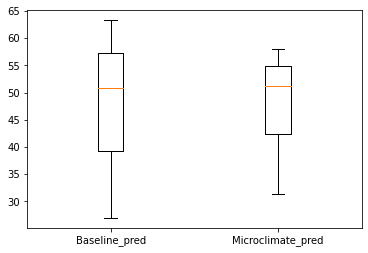

In [32]:
plt.boxplot([Y_pred_j9, Y_pred_j9_envi])
plt.xticks([1,2],['Baseline_pred', 'Microclimate_pred'])
print(Y_pred_j9.mean())
print(Y_pred_j9_envi.mean())
print('mu:', Y_pred_j9.mean()- Y_pred_j9_envi.mean())

# Two-Sample T Test


mean differences in CHWTON = $ \mu_{baseline} - \mu_{microclimate}$ 

$ H_0: $ Mean of CHWTON in baseline and microclimate are the same

$ H_1: $ Mean of CHWTON in baseline and microclimate are NOT the same

## 10.1 calculate standard deviation

In [33]:
# 1.variance
var_baseline = Y_pred_j9.var(ddof = 1)
var_micro = Y_pred_j9_envi.var(ddof = 1)
print('var:',var_baseline, var_micro)

# 2. standard deviation
s = np.sqrt((var_baseline + var_micro)/2)
print('s:',s)

var: 141.17757226856082 80.71497188718679
s: 10.53310362988392


## 10.2 calculate T-statistic

In [34]:
import scipy.stats as stats
t_stat, p_val = stats.ttest_ind(Y_pred_j9, Y_pred_j9_envi, equal_var=False)
print('t statistics: ', t_stat)
print('p value: ', p_val)

t statistics:  -0.04885752290994671
p value:  0.9613805960854438


P value is not less that 0.05. We cannot reject the null hypothesis. There is no significant difference between the transaction amount of fraud and non fraudulent transaction

# 11. Plot

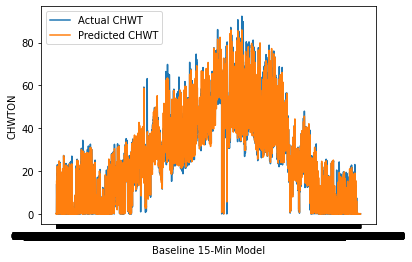

In [35]:
####### Plotting Baseline Model for all 2018 15-min Data #######

## This is a big graph, will be slow to run but gives visual of prediction accuracy
# %matplotlib qt
plt.xlabel('Baseline 15-Min Model')
plt.ylabel('CHWTON')
plt.plot(ModelPred['Actual CHWTON'], label = 'Actual CHWT')
plt.plot(ModelPred['Predicted CHWTON'], label = 'Predicted CHWT')
plt.legend()
plt.show()

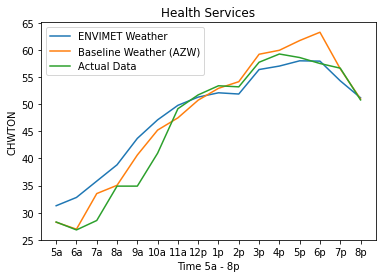

In [36]:
#  Plotting ENVI-met vs AZW vs Actual Data for June 9 from 5a - 8p

positions = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
labels = ['5a', '6a', '7a', '8a', '9a', '10a', '11a', '12p', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p']

# plot EnviMet vs AZ_Weather results
plt.xlabel('Time 5a - 8p')
plt.ylabel('CHWTON')
plt.xticks(positions, labels)
plt.plot(Pred['Microclimate Predictions'], label = 'ENVIMET Weather')
plt.plot(Pred['Baseline Predictions (AZW)'], label = 'Baseline Weather (AZW)')
plt.plot(Pred['Actual'], label = 'Actual Data')
plt.title(bldname)
plt.legend()

## show graphs
plt.show()